In [1]:
import torch

# To resolve memory leaks giving received 0 items from anecdata
# Reference link https://github.com/pytorch/pytorch/issues/973
torch.multiprocessing.set_sharing_strategy("file_system")

from torch.utils.data import DataLoader
import logging
import os
import sys
import pkg_resources

# sys.path.append("/fsx-repligen/piyusht1/projects/uCO3D/uco3d/")
sys.path.append("../../uco3d/")
from uco3d.uco3d_dataset import UCO3DDataset, UCO3DFrameDataBuilder
from uco3d.dataset_utils.scene_batch_sampler import (
    SceneBatchSampler,
)

logger = logging.getLogger("pixar_replay.core.dataset.uco3d")
sh = logging.StreamHandler()
logger.addHandler(sh)
logger.setLevel(logging.DEBUG)



In [2]:
NO_BLOBS_KWARGS = {
    "dataset_root": "",
    "load_images": False,
    "load_depths": False,
    "load_masks": False,
    "load_depth_masks": False,
    "box_crop": False,
    "image_height": 800,
}
SCENE_BATCH_SAMPLER_KWARGS = {
    "dataset_root": "",
    # "image_height": 800,
    # "image_width": 800,
    "load_depths": True,
    # "load_frames_from_videos": False,
}

DATASET_ROOT = pkg_resources.resource_filename(__name__, "data")
METADATA_FILE = os.path.join(DATASET_ROOT, "metadata_1766.sqlite")
# METADATA_FILE = "/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export/metadata_all.sqlite"
# frame_data_builder_args = NO_BLOBS_KWARGS
frame_data_builder_args = SCENE_BATCH_SAMPLER_KWARGS

#Can create frame_data_builder explicitly or use frame_data_builder_args
frame_data_builder = UCO3DFrameDataBuilder(
    dataset_root="/fsx-repligen/piyusht1/projects/uCO3D_SfM/export_reconstruction_2000/dataset_export",
    # dataset_root="/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export",
    load_frames_from_videos=True,
    load_depths=True,
    use_cache=True,
    image_height = 800,
    load_point_clouds=True,
)

dataset = UCO3DDataset(
    dataset_root="/fsx-repligen/piyusht1/projects/uCO3D_SfM/export_reconstruction_2000/dataset_export",
    # dataset_root="/fsx-repligen/shared/datasets/uCO3D/batch_reconstruction/dataset_export",
    sqlite_metadata_file=METADATA_FILE,
    remove_empty_masks=False,   
    frame_data_builder_args = frame_data_builder_args,
)

images_per_seq_options = [8]
scene_batch_sampler = SceneBatchSampler(
    dataset=dataset,
    batch_size=48,
    num_batches=1,
    images_per_seq_options=images_per_seq_options,
)

def my_collate_fn(batch):
    return [batch]

num_workers = 0
dataloader = DataLoader(
    dataset,
    batch_sampler=scene_batch_sampler,
    num_workers=num_workers,
    collate_fn=dataset.frame_data_type.collate,
)


In [3]:
sequences = dataset.sequence_names()
print(type(sequences))

<class 'pandas.core.indexes.base.Index'>


In [7]:
dataset.meta
# seq = "80-10569-13888"
seq = "86-36386-31391"
# seq = "204-26426-11398"
# seq = "11-20136-70498"
# seq = "578-73002-95753"
# seq = "54-70193-22266"
# seq = "100-23060-30900"
seq_frame_ids = list(dataset.sequence_frames_in_order(seq))
ts, frame_id, idx = seq_frame_ids[42]

In [8]:
seq_frame_ids

[Pandas(frame_timestamp=0.0, frame_number=0, idx=7400),
 Pandas(frame_timestamp=0.033707865168539325, frame_number=1, idx=7401),
 Pandas(frame_timestamp=0.1348314606741573, frame_number=2, idx=7402),
 Pandas(frame_timestamp=0.33707865168539325, frame_number=3, idx=7403),
 Pandas(frame_timestamp=0.5056179775280899, frame_number=4, idx=7404),
 Pandas(frame_timestamp=0.6741573033707865, frame_number=5, idx=7405),
 Pandas(frame_timestamp=0.8764044943820224, frame_number=6, idx=7406),
 Pandas(frame_timestamp=1.044943820224719, frame_number=7, idx=7407),
 Pandas(frame_timestamp=1.2134831460674156, frame_number=8, idx=7408),
 Pandas(frame_timestamp=1.4157303370786516, frame_number=9, idx=7409),
 Pandas(frame_timestamp=1.5842696629213482, frame_number=10, idx=7410),
 Pandas(frame_timestamp=1.7528089887640448, frame_number=11, idx=7411),
 Pandas(frame_timestamp=1.9550561797752808, frame_number=12, idx=7412),
 Pandas(frame_timestamp=2.1235955056179776, frame_number=13, idx=7413),
 Pandas(frame_t

Showing sequence 86-36386-31391


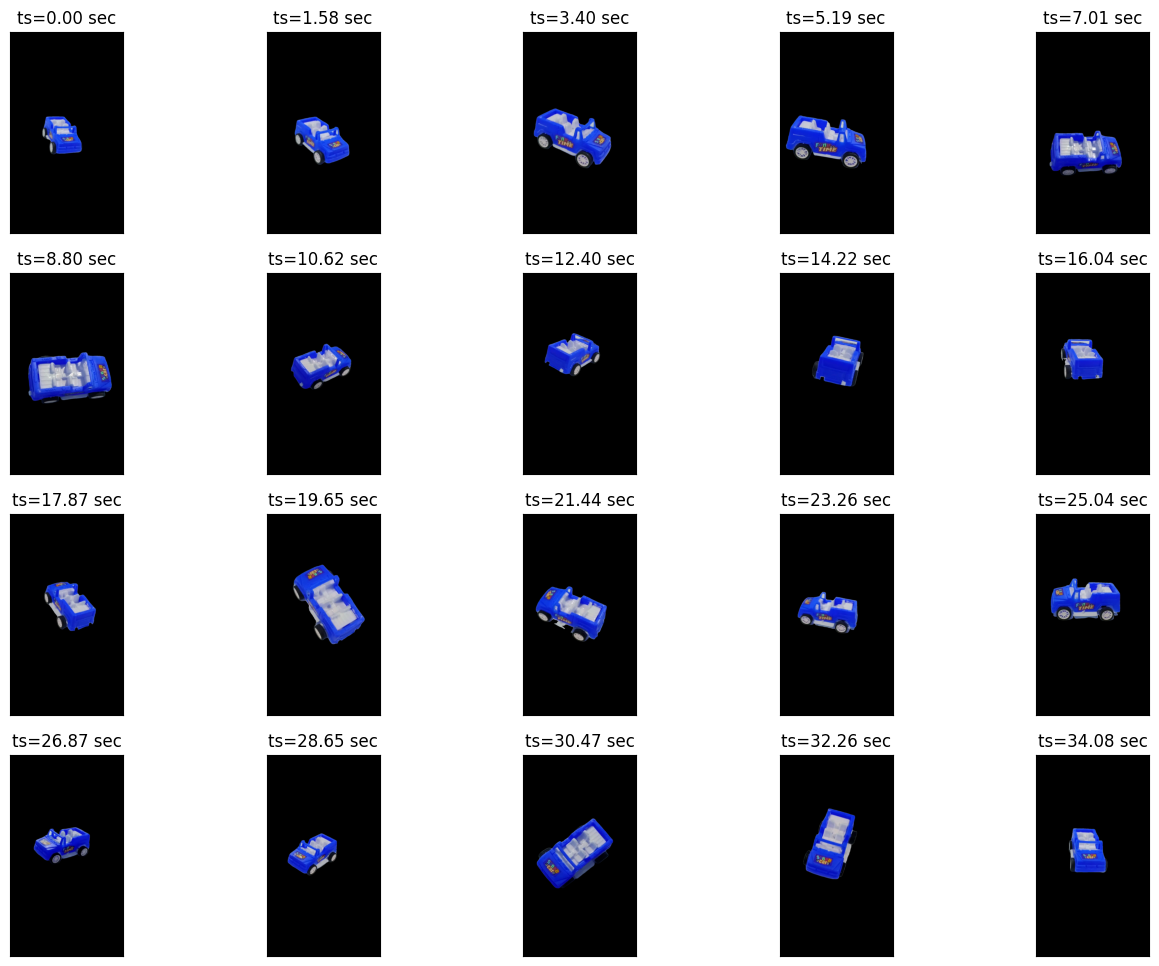

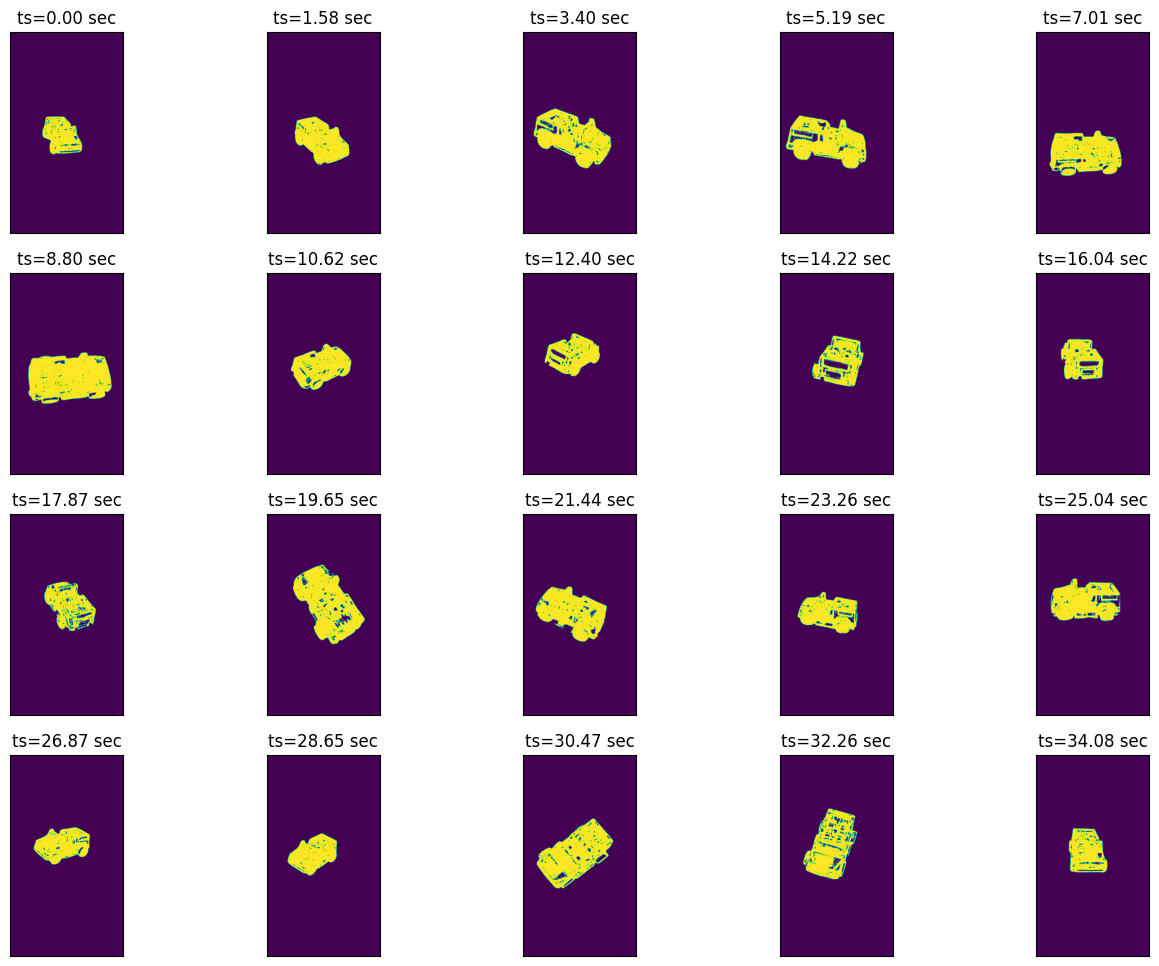

In [9]:
from pytorch3d.vis.plotly_vis import plot_scene
from IPython.display import display
from matplotlib import pyplot as plt
from uco3d.dataset_utils.uco3d_cameras import join_uco3d_cameras_as_batch
from pytorch3d.renderer.camera_utils import join_cameras_as_batch

print("Showing sequence", seq)
n_vis_frames = 20
n_image_cols = 5
ax = plt.figure(figsize=(16, 12)).subplots(-(-n_vis_frames // n_image_cols), n_image_cols).reshape(-1)
for slot in ax:
    slot.get_xaxis().set_visible(False)
    slot.get_yaxis().set_visible(False)

interval = len(seq_frame_ids) // n_vis_frames
for slot, (_, frame_id, _) in zip(ax, seq_frame_ids[::interval]):
    frame = dataset[seq, frame_id]  # loading and cropping happens on this call
    masked_im = frame.image_rgb * frame.fg_probability
    slot.imshow(masked_im.permute(1, 2, 0).data.numpy())
    slot.set_title(f"ts={frame.frame_timestamp:.2f} sec")

#Visualize depths
ax = plt.figure(figsize=(16, 12)).subplots(-(-n_vis_frames // n_image_cols), n_image_cols).reshape(-1)
for slot in ax:
    slot.get_xaxis().set_visible(False)
    slot.get_yaxis().set_visible(False)

interval = len(seq_frame_ids) // n_vis_frames
for slot, (_, frame_id, _) in zip(ax, seq_frame_ids[::interval]):
    frame = dataset[seq, frame_id]  # loading and cropping happens on this call
    masked_im = frame.depth_map * frame.fg_probability
    slot.imshow(masked_im.permute(1, 2, 0).data.numpy())
    slot.set_title(f"ts={frame.frame_timestamp:.2f} sec")
    

In [10]:
from uco3d.dataset_utils.uco3d_cameras import join_uco3d_cameras_as_batch
cameras = join_uco3d_cameras_as_batch([dataset.meta[seq, frame_id].camera for _, frame_id, _ in seq_frame_ids[::interval]])
plot_scene({"main": {"cameras": cameras}}, camera_scale=0.3)

ValueError: struct UCO3DCameras(R=tensor([[[ 0.1777,  0.5648,  0.8059],
         [-0.7113, -0.4922,  0.5018],
         [ 0.6801, -0.6624,  0.3143]],

        [[-0.5034, -0.2889, -0.8143],
         [ 0.7050, -0.6823, -0.1937],
         [-0.4996, -0.6716,  0.5472]],

        [[-0.8129, -0.2423, -0.5296],
         [ 0.4732, -0.8048, -0.3582],
         [-0.3394, -0.5418,  0.7689]],

        [[-0.9802, -0.0677, -0.1859],
         [ 0.1513, -0.8620, -0.4838],
         [-0.1275, -0.5024,  0.8552]],

        [[-0.9999,  0.0150,  0.0035],
         [-0.0152, -0.9981, -0.0599],
         [ 0.0026, -0.0600,  0.9982]],

        [[-0.9995,  0.0250, -0.0189],
         [-0.0296, -0.9529,  0.3020],
         [-0.0104,  0.3024,  0.9531]],

        [[-0.8754,  0.3819,  0.2962],
         [-0.3739, -0.9235,  0.0856],
         [ 0.3063, -0.0358,  0.9513]],

        [[-0.6875,  0.4598,  0.5620],
         [-0.5552, -0.8317,  0.0012],
         [ 0.4680, -0.3112,  0.8271]],

        [[-0.3728,  0.5954,  0.7117],
         [-0.7071, -0.6789,  0.1976],
         [ 0.6009, -0.4296,  0.6741]],

        [[ 0.1315,  0.6695,  0.7311],
         [-0.7007, -0.4589,  0.5463],
         [ 0.7013, -0.5841,  0.4087]],

        [[ 0.3075,  0.8218,  0.4796],
         [-0.6196, -0.2096,  0.7564],
         [ 0.7221, -0.5298,  0.4448]],

        [[ 0.3732,  0.9273,  0.0281],
         [-0.5969,  0.2168,  0.7725],
         [ 0.7103, -0.3051,  0.6344]],

        [[ 0.7865,  0.6131,  0.0739],
         [-0.2579,  0.2174,  0.9414],
         [ 0.5611, -0.7595,  0.3291]],

        [[-0.9779, -0.1367, -0.1582],
         [ 0.1865, -0.9124, -0.3642],
         [-0.0946, -0.3857,  0.9178]],

        [[-0.9952,  0.0654,  0.0728],
         [-0.0886, -0.9179, -0.3868],
         [ 0.0416, -0.3914,  0.9193]],

        [[-0.8733,  0.2838,  0.3960],
         [-0.4100, -0.8671, -0.2828],
         [ 0.2631, -0.4093,  0.8736]],

        [[-0.7283,  0.4330,  0.5311],
         [-0.5434, -0.8372, -0.0626],
         [ 0.4175, -0.3342,  0.8450]],

        [[-0.8574,  0.5060,  0.0942],
         [-0.4247, -0.7989,  0.4260],
         [ 0.2909,  0.3252,  0.8998]],

        [[-0.4122,  0.8219,  0.3932],
         [-0.7231, -0.5577,  0.4075],
         [ 0.5542, -0.1164,  0.8242]],

        [[ 0.0044,  0.6263,  0.7796],
         [-0.7640, -0.5009,  0.4067],
         [ 0.6452, -0.5974,  0.4762]]]), T=tensor([[-2.3442,  1.9829,  3.8899],
        [ 2.3918,  3.4709,  5.3408],
        [ 2.5185,  3.0956,  2.9246],
        [ 2.2281,  2.5708,  2.0238],
        [ 1.8078,  0.3793,  1.3117],
        [ 1.5899, -0.6073,  0.4582],
        [ 0.5064,  0.5362,  1.7561],
        [-0.1732,  1.8659,  1.8954],
        [-1.4356,  1.7166,  1.1855],
        [-2.1088,  2.1609,  2.7901],
        [-3.0268,  1.3654,  3.0459],
        [-3.1276, -0.1036,  1.4616],
        [-3.1050,  2.0198,  3.2528],
        [ 2.2328,  2.6085,  3.2680],
        [ 1.8427,  2.6096,  1.7656],
        [ 0.8670,  2.2489,  2.6088],
        [ 0.3424,  1.3331,  2.7459],
        [ 0.7218, -1.5307,  0.7858],
        [-0.8841, -0.1546,  0.8707],
        [-1.8669,  1.9007,  2.4987]]), focal_length=tensor([[3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229],
        [3.0556, 3.0229]]), principal_point=tensor([[ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073],
        [ 0.0049, -0.0073]]), colmap_distortion_coeffs=tensor([[ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1088, -0.2825,  0.0022, -0.0040,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]]), device='cpu', in_ndc=True, image_size=None) is not a Cameras, Meshes, Pointclouds, , RayBundle or HeterogeneousRayBundle object.

Text(0.5, 1.0, 'Camera trajectory projection')

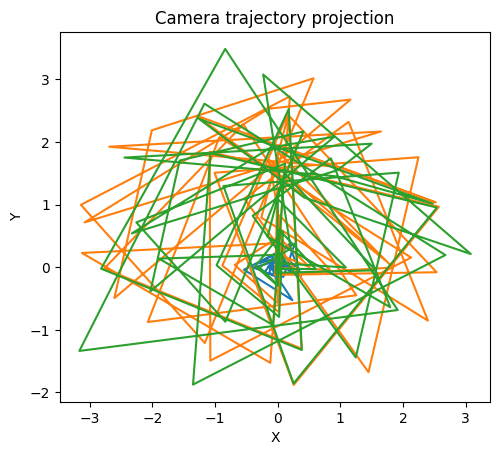

In [ ]:
import numpy as np
def get_camera_center_world(viewpoint):
    # center = -inv(R) @ T; R is orthogonal
    return -np.array(viewpoint.R).T @ np.array(viewpoint.T)[:, None]

centers = np.hstack([get_camera_center_world(dataset.meta[seq, frame_id].camera) for _, frame_id, _ in seq_frame_ids[::interval]])
plt.figure()
plt.plot(centers[0], centers[1])
plt.gca().set_aspect("equal")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Camera trajectory projection")

In [11]:
seq_frame_ids[::interval]

[Pandas(frame_timestamp=0.0, frame_number=0, idx=7400),
 Pandas(frame_timestamp=1.5842696629213482, frame_number=10, idx=7410),
 Pandas(frame_timestamp=3.4044943820224716, frame_number=20, idx=7420),
 Pandas(frame_timestamp=5.191011235955056, frame_number=30, idx=7430),
 Pandas(frame_timestamp=7.011235955056179, frame_number=40, idx=7440),
 Pandas(frame_timestamp=8.797752808988763, frame_number=50, idx=7450),
 Pandas(frame_timestamp=10.617977528089888, frame_number=60, idx=7460),
 Pandas(frame_timestamp=12.404494382022472, frame_number=70, idx=7470),
 Pandas(frame_timestamp=14.224719101123595, frame_number=80, idx=7480),
 Pandas(frame_timestamp=16.04494382022472, frame_number=90, idx=7490),
 Pandas(frame_timestamp=17.865168539325843, frame_number=100, idx=7500),
 Pandas(frame_timestamp=19.651685393258425, frame_number=110, idx=7510),
 Pandas(frame_timestamp=21.43820224719101, frame_number=120, idx=7520),
 Pandas(frame_timestamp=23.258426966292134, frame_number=130, idx=7530),
 Pandas(f

In [12]:
from pytorch3d.structures import Pointclouds
from pytorch3d.implicitron.tools.point_cloud_utils import render_point_cloud_pytorch3d
from pytorch3d.renderer import (
    AlphaCompositor,
    PointsRasterizationSettings,
)
from pytorch3d.implicitron.dataset.utils import load_pointcloud

from pytorch3d.renderer.cameras import PerspectiveCameras

from pytorch3d.implicitron.tools.video_writer import VideoWriter
from uco3d.uco3d_frame_data import UCO3DFrameData
from typing import List, Optional
import copy
from tqdm import tqdm
import numpy as np
import plyfile
import pytorch3d
from matplotlib import pyplot as plt


In [17]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

def _get_pytorch3d_camera_from_uco3d_camera(
    camera,
) -> PerspectiveCameras:
    assert camera is not None
    return PerspectiveCameras(
        focal_length=camera.focal_length,
        principal_point=camera.principal_point,
        R=camera.R,
        T=camera.T,
    )

def get_render_ims_from_rgb_pcl_cameras(image_rgb, cameras, point_cloud, device):
    # device = meshes.verts_padded().device
    # ok_idx = torch.where(meshes_idx==mi)[0]
    # camera_ = camera[ok_idx]
    cnt = cameras.get_camera_center()
    # cnt = (tuple(cnt[0].tolist()),)
    # lights = pytorch3d.renderer.PointLights(
    #     device=device,
    #     location=cnt,
    # )
    colors = point_cloud.features_padded()[[0]]
    colors = colors - colors.min(dim=1, keepdim=True).values
    colors = colors / colors.max(dim=1, keepdim=True).values
    point_cloud_to_rasterize = Pointclouds(
        points=point_cloud.points_padded()[[0]].float(),
        features=colors.clamp(0.0, 1.0),
    ).extend(cameras.R.shape[0])
    # mesh_to_rasterize = pytorch3d.structures.Meshes(
    #     verts=meshes.verts_padded()[[mi]].float(),
    #     faces=meshes.faces_padded()[[mi]].float(),
    #     textures=pytorch3d.renderer.TexturesVertex(
    #         colors.clamp(0.0, 1.0)
    #     )
    # ).extend(cameras.R.shape[0])
    rasterizer = pytorch3d.renderer.PointsRasterizer(
        cameras,
        PointsRasterizationSettings(
            image_size=image_rgb.shape[1:], radius=0.003, points_per_pixel=10
        ),
    )
    renderer = pytorch3d.renderer.PointsRenderer(
        rasterizer=rasterizer, compositor=AlphaCompositor()
    )
    render_ims = renderer(point_cloud_to_rasterize)
    return render_ims

def load_fusion_pcl(pcl_path: str, max_points: Optional[int] = None):
    with open(pcl_path, "rb") as f:
        plydata = plyfile.PlyData.read(f)
    pcl_data = np.stack(
        [
            np.array(plydata["vertex"][c]).astype(float)
            # for c in ("x", "y", "z", "red", "green", "blue", "nx", "ny", "nz")
            for c in ("x", "y", "z", "red", "green", "blue")
        ],
        axis=1,
    )
    if max_points is not None and pcl_data.shape[0] > max_points:
        prm = np.random.permutation(pcl_data.shape[0])[:max_points]
        prm = np.randperm(pcl_data.shape[0])[:max_points]
        pcl_data = pcl_data[prm]
    # points_3d, points_rgb, points_normals = np.split(pcl_data, 3, axis=1)
    points_3d, points_rgb = np.split(pcl_data, 2, axis=1)
    # return points_3d, points_rgb / 255.0, points_normals
    return points_3d, points_rgb / 255.0

def visualize_reprojected_pointcloud(
    frame_data: List[UCO3DFrameData],
    video_path: str,
    *,
    pcl: Optional[Pointclouds] = None,
    use_gpu: bool = True,
    fps: int = 20,
    verbose: bool = True,
    n_frames: Optional[int] = None,
    max_render_size: int = 1000,
    load_sparse: bool = False,
    use_render_ims: bool = False,
):
    if load_sparse:
        point_cloud = load_pointcloud(frame_data[0].sequence_point_cloud_path)
    else:
        #following two lines for loading fusion_filtered_point_cloud
        pcl_path = f"/fsx-repligen/piyusht1/projects/uCO3D_SfM/export_reconstruction_2000/{frame_data[0].sequence_name}/mapper_output/0/dense/fused_point_cloud_filtered.ply"
        _pts, _rgb = load_fusion_pcl(pcl_path)
        # _pts, _rgb = load_fusion_pcl(frame_data[0].sequence_point_cloud_path)
        point_cloud = Pointclouds(
            points=torch.from_numpy(_pts[None]).float(),
            features=torch.from_numpy(_rgb[None]).float(),
            # normals=torch.from_numpy(_nrm[None]).float(),
        )
    pcl = point_cloud.to(device)
    if verbose:
        print(f"Rendering reprojected pointcloud {video_path} ...")

    vw = VideoWriter(
        cache_dir=None,
        ffmpeg_bin="ffmpeg",
        out_path=video_path,
        fps=fps,
        output_format="visdom",
    )

    if n_frames and 0 < n_frames < len(frame_data):
        frames_show = (
            np.round(np.linspace(0, len(frame_data) - 1, n_frames)).astype(int).tolist()
        )
    else:
        frames_show = list(range(len(frame_data)))

    avg_frame_size = (
        torch.stack([fd.image_size_hw for fd in frame_data]).float().mean(dim=0)
    )
    avg_frame_size = avg_frame_size * (max_render_size / avg_frame_size.max())
    avg_frame_size = avg_frame_size.round().long().tolist()

    for frame_i in tqdm(frames_show):
        render_camera = _get_pytorch3d_camera_from_uco3d_camera(frame_data[frame_i].camera)
        
        im = frame_data[frame_i].image_rgb
        if use_gpu:
            render_camera = render_camera.to(device)
        
        if use_render_ims:
            image_pcl = get_render_ims_from_rgb_pcl_cameras(
                im, render_camera, pcl, device
            )
            vis_image = image_pcl[0, ..., :3].permute(2,0,1).cpu().numpy() * 0.5 + im.data.numpy() * 0.5
            # pdb.set_trace()
            vw.write_frame(vis_image)
            # plt.imsave("/fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_image.jpeg", 
            #            image_pcl[0, ..., :3].cpu().numpy() * 1.0)
        else:
            rout = render_point_cloud_pytorch3d(
                render_camera,
                pcl,
                render_size=im.shape[1:],
                point_radius=0.008,
                topk=10,
                eps=1e-2,
                bg_color=None,
                bin_size=0,
            )
            im_pts = rout[0].to(im)
            mask = rout[1].to(im)
            frame = (1 - mask) * im[None] + mask * im_pts
            frame = torch.nn.functional.interpolate(frame, size=avg_frame_size)
            vw.write_frame(frame[0].clamp(0.0, 1.0).cpu().numpy())

    vw.get_video()

In [25]:
seq_frame_data_list = []
sequences = dataset.sequence_names()
n_vis_frames = 200
# seq = "165-20584-89558"
sequences = ["1-50292-57542", "1-52747-77186", "4-19713-19337"]
for seq in sequences[:]:
    # if f"{seq}_from_video_latest.mp4" not in os.listdir("/fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_videos_fused_filtered"):
    print("Current sequence ", seq)
    seq_frame_ids = list(dataset.sequence_frames_in_order(seq))
    interval = len(seq_frame_ids) // n_vis_frames
    seq_frame_data = [dataset[seq, frame_id] for (_, frame_id, _) in seq_frame_ids[::interval]] # loading and cropping happens on this call
    visualize_reprojected_pointcloud(frame_data=seq_frame_data, video_path = f"/fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_videos_fused_filtered/{seq}_from_video_latest.mp4", use_render_ims=False)


Current sequence  1-50292-57542
Rendering reprojected pointcloud /fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_videos_fused_filtered/1-50292-57542_from_video_latest.mp4 ...


  8%|▊         | 17/200 [02:01<21:53,  7.18s/it]

In [ ]:
visualize_reprojected_pointcloud(frame_data=seq_frame_data, video_path = "/fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_video.mp4")

Rendering reprojected pointcloud /fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_video.mp4 ...


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


In [ ]:
seq_frame_data_list = []
sequences = dataset.sequence_names()
for seq in sequences[0:1]:
    print("Current sequence ", seq)
    seq_frame_ids = list(dataset.sequence_frames_in_order(seq))
    seq_frame_data = [dataset[seq, frame_id] for (_, frame_id, _) in seq_frame_ids] # loading and cropping happens on this call
    seq_frame_data[0]
    visualize_reprojected_pointcloud(frame_data=seq_frame_data, video_path = f"/fsx-repligen/piyusht1/projects/uCO3D/uco3d/tests/data/pcl_rgb/pcl_videos/{seq}.mp4")

In [ ]:
from uco3d.dataset_utils.uco3d_cameras import join_uco3d_cameras_as_batch, opencv_image_undistorter, _opencv_from_cameras_projection_uco3d, _uco3d_cameras_from_opencv_projection
sequences = dataset.sequence_names()
seq = sequences[0]
print("Current sequence ", seq)
seq_frame_ids = list(dataset.sequence_frames_in_order(seq))
seq_frame_data = [dataset[seq, frame_id] for (_, frame_id, _) in seq_frame_ids]
